#**Use of the Fuzzy C-Means Algorithm**
*  Implement the Fuzzy C-Means algorithm
*  Apply it to a grayscale image
*  Visualize the segmentation result using a heatmap





In [1]:
import numpy as np

#initialiser la matrice d’appartenance
def initialiser_matrice_appartenance(nombre_cluster,nombre_pixel):
  U=np.random.rand(nombre_cluster,nombre_pixel)
  U_some=np.sum(U,axis=0,keepdims=True)
  U=U/U_some
  return U

#Calculer les centres de cluster
def calcul_centre(x,m,U):
  Um=U**m
  Us=Um*x
  Num=np.sum(Us,axis=1)
  denum=np.sum(Um,axis=1)
  C=Num/denum
  return C

#inialiser les valeurs de matrice d’appartenance
def mettre_a_jour_matrice_appartenance(x,m,C):
#verifier le nombre de cluster et le nombre de pixel sur le tableau qui a ete cree avant
  nombre_cluseter= C.shape[0]
  nombre_pixel=x.shape[0]
#cree un tableau avec des zero pour la nouvelle matrice dappartenance
  U_nouv = np.zeros((nombre_cluseter, nombre_pixel))
#la valeur expo
  L=(2/(m-1))
#parcourir les pixel et les cluster
  for i in range(nombre_pixel):
    distances_i = np.abs(x[i] - C)
    #eviter la division sur 0
    distances_i[distances_i == 0] = 1e-10
    for j in range(nombre_cluseter):
      dis=(distances_i[j]/distances_i)**L
      denum=np.sum(dis)
    #nouveau degré d'appartenance
      U_nouv[j,i]=1/denum

  return U_nouv

def fuzzy_c_means(x, nombre_cluseter, m, epsilon, max_iter):
  nombre_pixel = x.shape[0]

  # appelle de la fonction U
  U = initialiser_matrice_appartenance(nombre_cluseter, nombre_pixel)

  for it in range(max_iter):
   #appelle de la fonction calcule de centre clusters
    C = calcul_centre(x, m, U)

    # On appelle aussi la matrice qui a ete inialiser apres le calcule des centres
    U_nouv = mettre_a_jour_matrice_appartenance(x, m, C)

    # vérifier si le modèle a convergé ou non
    diff = np.linalg.norm(U_nouv - U)

    # condition d'arrêt
    if diff < epsilon:
      break

    # préparer l'itération suivante
    U = U_nouv

  return U_nouv, C


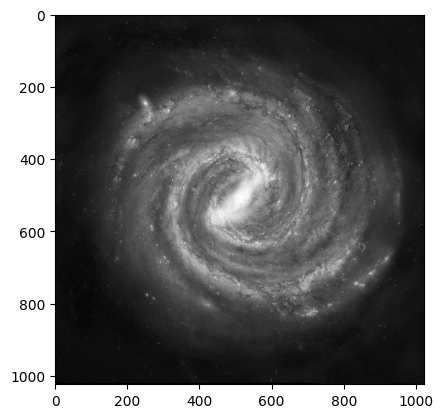

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("/content/milky-way-nvg.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

import matplotlib.pyplot as plt
# convertir image en float
image = image.astype(np.float32)

# Aplatir l'image en un vecteur 1D
x = image.flatten()

In [3]:
# paramètres
K = 2
m = 2
epsilon = 1e-6
max_iter = 150

U_final, C_final = fuzzy_c_means(x, nombre_cluseter=K, m=m, epsilon=epsilon, max_iter=max_iter)

print("Centres trouvés :", C_final)

Centres trouvés : [ 27.56649697 113.15227589]


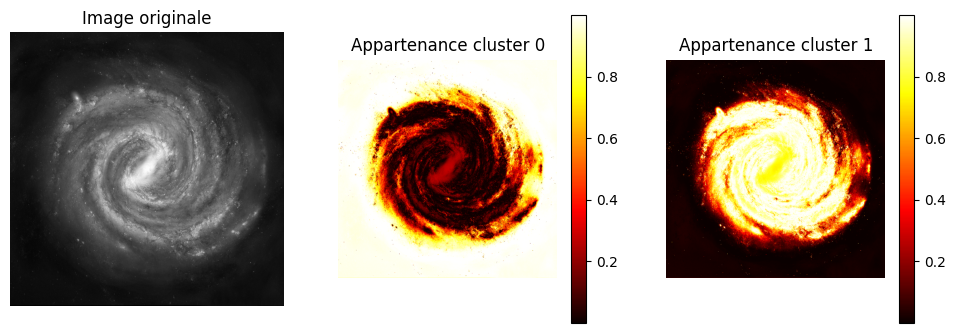

In [4]:
h, w = image.shape

U_cluster0 = U_final[0, :].reshape((h, w))
U_cluster1 = U_final[1, :].reshape((h, w))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Image originale")
plt.imshow(image, cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Appartenance cluster 0")
plt.imshow(U_cluster0, cmap='hot')
plt.colorbar()
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Appartenance cluster 1")
plt.imshow(U_cluster1, cmap='hot')
plt.colorbar()
plt.axis("off")

plt.show()


In [5]:
def calcul_centre_couleur(x, m, U):
    Um = U**m
    # produit matriciel
    Num = Um @ x
    # somme des degrés d'appartenance flous pour chaque cluster
    denum = np.sum(Um, axis=1, keepdims=True)
    C = Num / denum
    return C

In [6]:
def inialiser_matrice_appartenance_couleur(x, m, C):

    nombre_cluseter = C.shape[0]
    nombre_pixel = x.shape[0]
    U_nouv = np.zeros((nombre_cluseter, nombre_pixel))

    L = 2 / (m - 1)

    for i in range(nombre_pixel):
        # diff et norme euclidienne en 3D
        diff = x[i] - C
        distances_i = np.linalg.norm(diff, axis=1)
        distances_i[distances_i == 0] = 1e-10

        for j in range(nombre_cluseter):
            dis = (distances_i[j] / distances_i)**L
            denum = np.sum(dis)
            U_nouv[j, i] = 1.0 / denum

    return U_nouv

In [7]:
def fuzzy_c_means_couleur(x, nombre_cluseter=2, m=2, epsilon=1e-5, max_iter=100):

    nombre_pixel = x.shape[0]
    U = initialiser_matrice_appartenance(nombre_cluseter, nombre_pixel)

    for it in range(max_iter):
        C = calcul_centre_couleur(x, m, U)
        U_nouv = inialiser_matrice_appartenance_couleur(x, m, C)

        diff = np.linalg.norm(U_nouv - U)
        if diff < epsilon:
            break

        U = U_nouv

    return U_nouv, C

In [8]:
image_bgr = cv2.imread("/content/milky-way.jpg", cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

h, w, c = image_rgb.shape

# convertir en float et normaliser [0,1]
image_float = image_rgb.astype(np.float32) / 255.0
#aplatir limage
x_couleur = image_float.reshape(-1, 3)

In [9]:
U_final_c, C_final_c = fuzzy_c_means_couleur(
    x_couleur,
    nombre_cluseter=K,
    m=m,
    epsilon=epsilon,
    max_iter=max_iter
)
print("Centres trouvés (RGB normalisé) :", C_final_c)

Centres trouvés (RGB normalisé) : [[0.09357932 0.10673454 0.14353474]
 [0.46765892 0.42749687 0.47267712]]


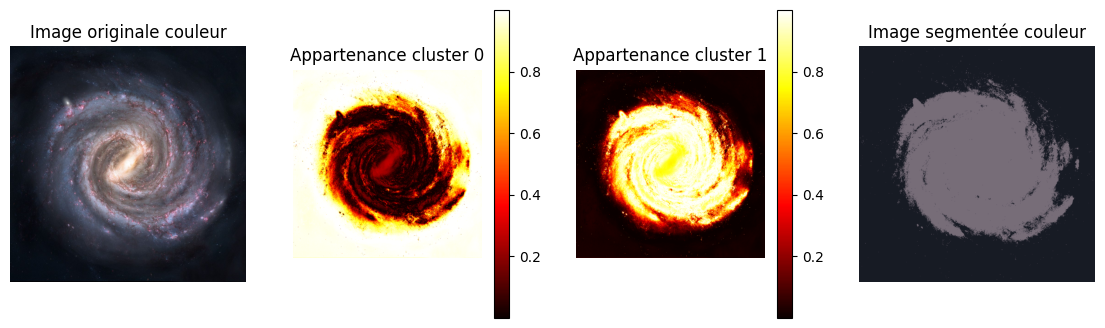

In [10]:
U_cluster0_c = U_final_c[0, :].reshape((h, w))
U_cluster1_c = U_final_c[1, :].reshape((h, w))

#  construire une image segmentée couleur
labels = np.argmax(U_final_c, axis=0)
segmented = C_final_c[labels]
segmented = segmented.reshape(h, w, 3)
plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.title("Image originale couleur")
plt.imshow(image_rgb)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Appartenance cluster 0")
plt.imshow(U_cluster0_c, cmap='hot')
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Appartenance cluster 1")
plt.imshow(U_cluster1_c, cmap='hot')
plt.colorbar()
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Image segmentée couleur")
plt.imshow(segmented)
plt.axis("off")

plt.show()